# Top texts by field and country

Trying to extract top texts taught in a given institution or location.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
import networkx as nx
import math

from collections import Counter
from itertools import combinations

from sqlalchemy.sql import functions as func
from sqlalchemy.orm import aliased
from sqlalchemy.dialects.postgresql import array_agg

Import from v1_db.py
The following lines were added to local v1_db.py to include instituions:

Institution = Base.classes.institution

InstitutionDocument = Base.classes.institution_document

In [3]:
from osp_graphs.v1_db import session, Text, Field, Subfield, SubfieldDocument, Citation, Document, Institution, InstitutionDocument

Create function to extract texts tought at a given institution. Count is included in the query to allow us to measure a frequency for plotting. 

In [4]:
def inst_text(location, field, n):
    
    #main query (find all texts taught in a university)
    count = func.count(Citation.text_id)
    
    #query citation table - get all the citations in a given country
    citation_query = (session
                     .query(Citation.id)
                     .join(Document, InstitutionDocument, Institution)
                     .filter(Institution.country == location))
    
    field_query = (session
                  .query(Text.id, Text.title, count)
                  .join(Citation, Document, SubfieldDocument, Subfield, Field)
                  .filter(Citation.id.in_(citation_query))
                  .filter(Field.name == field)
                  .filter(Text.valid == True)
                  .filter(Text.display==True)
                  .group_by(Text.id)
                  .order_by(count.desc())
                  .limit(n))
    
    # if you cast as a set, it will be unordered
    return field_query.all()


In [5]:
loc_texts = inst_text('US', 'Philosophy', 600)
#loc_texts 

create empty graph

In [6]:
graph = nx.Graph()

Separate the tuples into individual lists. This allows us to use the data to identify texts and add nodes without errors.

In [7]:
text_id_only = [x[0] for x in loc_texts]
text_count = [x[2] for x in loc_texts]

In [8]:
doc_texts = (session
            .query(array_agg(Citation.text_id))
            .join(Text, Citation.text_id==Text.id)
            .filter(Text.valid==True)
            .filter(Text.display==True)
            .filter(Text.id.in_(text_id_only))
            .group_by(Citation.document_id))

build counter dictionary, add edges to the graph

In [9]:
edges = Counter()

for ids in doc_texts:
    for tid1, tid2 in combinations(sorted(ids[0]), 2):
        edges[tid1, tid2] += 1

#square root modification 
for (tid1, tid2), count in edges.items():
    #sqr_count = (count * count) / 10
    #root_count = math.sqrt(count)
    graph.add_edge(tid1, tid2, weight=count)

In [10]:
count = func.count(Citation.text_id)
texts = session.query(Text).filter(Text.id.in_(text_id_only))

Add nodes to the graph (include id, title, text count)

Constructed a method to match up count becuase the "texts" query sorts the order of the Text.id's in numerical order, adding a count and sorting by count seems to create errors.

In [11]:
#method to match up count and text
def find_count(text_id):
    for x in loc_texts:
        if(x[0] == text_id):
            return x[2]

def last_name(n):
    name = str(n)
    x_split = name.split(", ")
    
    #singular name authors (Plato, Aristotle, Homer, etc.)
    if len(x_split) == 1:
        author = x_split[0].replace("['", "").replace(".']", "")
    else:
        author = x_split[0].replace("['", "")
    
    return author

def title_format(n):
    t = str(n)
    t = t.replace("/", "").replace(";", "")
    title = t.split(":")
    
    
    #take the first element of the list 
    return title[0]


In [12]:
for text in texts:  
    #add node to the graph
    graph.add_node(text.id, title=title_format(text.title), author = last_name(text.authors), freq = find_count(text.id))

Plot out graph (draw_spring)

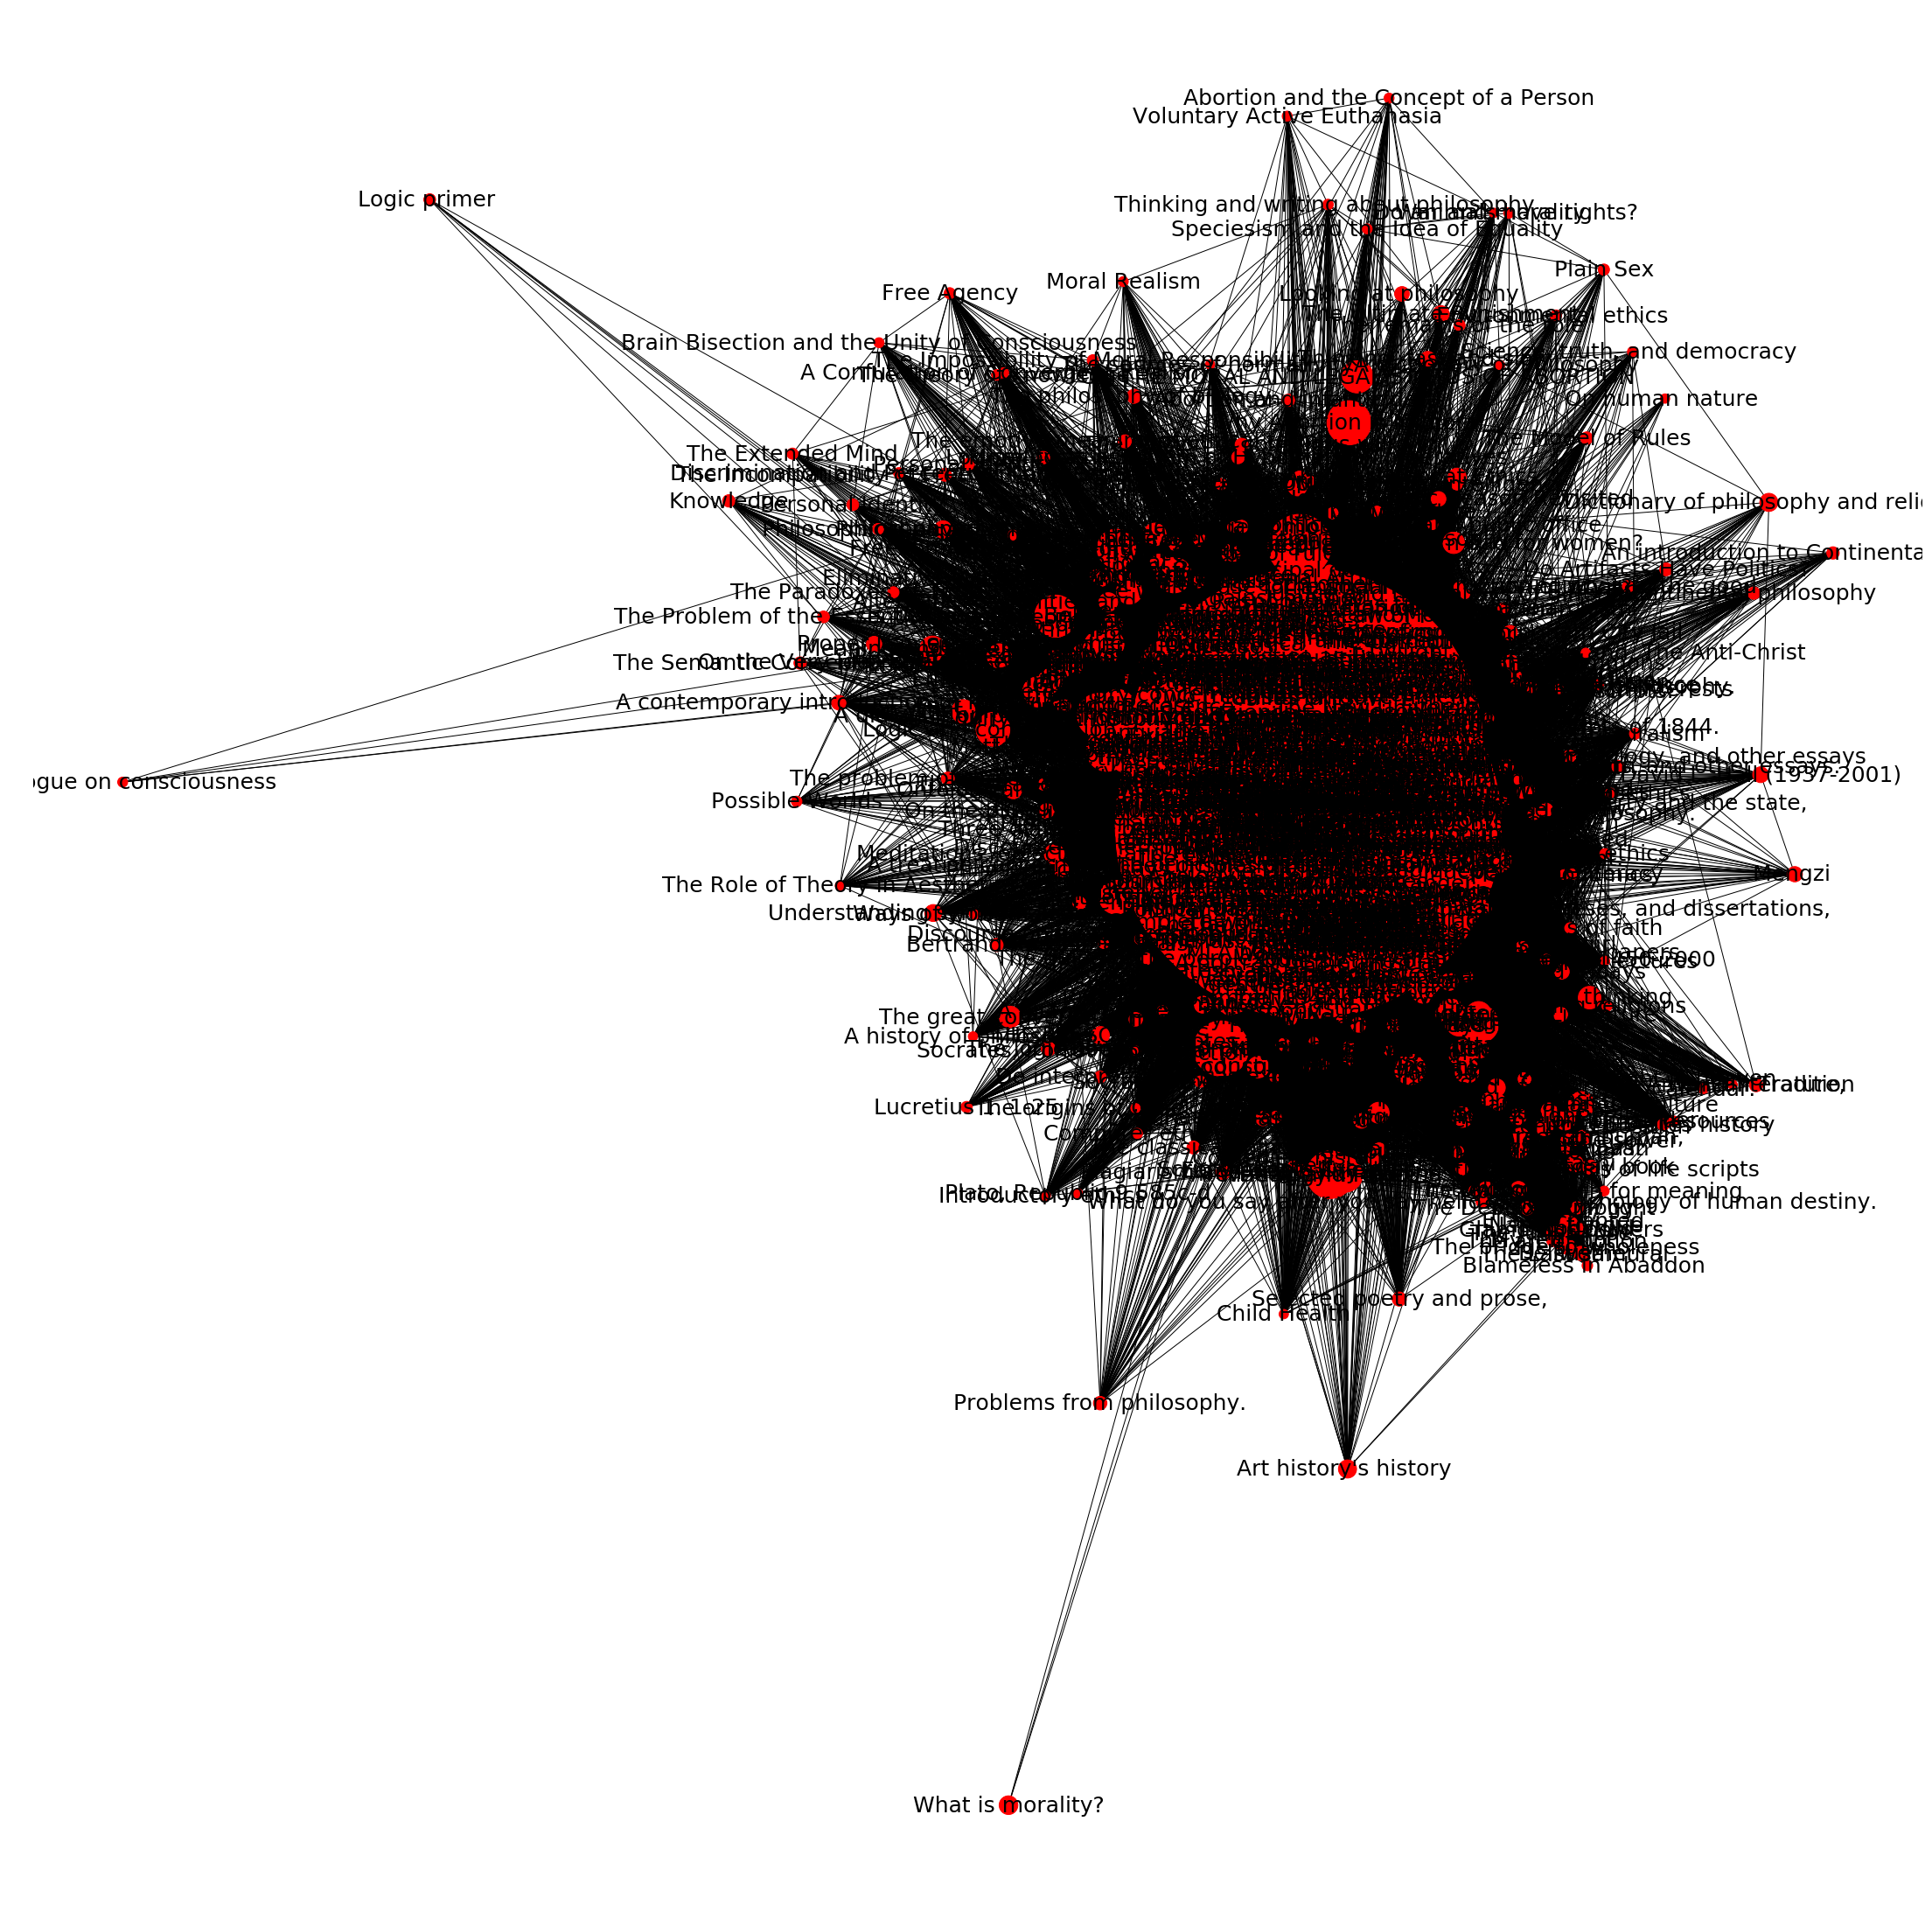

In [13]:
labels = nx.get_node_attributes(graph, 'title')
size = nx.get_node_attributes(graph, 'freq')

#check to see if the count and text.id matched up properly
#print(size)

plt.figure(figsize=(30, 30))

nx.draw_spring(graph, 
               font_size = 25, 
               labels=labels,
               #node_color=range(20),
               #cmap=plt.cm.Blues,
               node_size = [v**1.8 for v in size.values()])

In [14]:
nx.write_graphml(graph, 'phil_600_v1.graphml')
